# Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from scipy.stats import norm, expon, lognorm, gamma, poisson

# Load dataset 1

In [2]:
df = pd.read_csv('1_downloaded_data.csv', low_memory=False)

# 2 Co-/Applicant_sex distribution

The distibution of the applicant_sex/co_applicant_sex variables.

- 1 - Male
- 2 - Female
- 3 - Information not provided by applicant in mail, internet, or telephone application
- 4 - Not applicable
- 6 - Applicant selected both male and female

In [3]:
df['applicant_sex'].value_counts()

applicant_sex
1    128432
2     67355
3     23460
4       415
6       108
Name: count, dtype: int64

In [4]:
df['co_applicant_sex'].value_counts()

co_applicant_sex
5    123620
2     61316
1     24009
3     10660
4       132
6        33
Name: count, dtype: int64

# Remove unwanted categories

We want: 1 - Male, 2 - Female and 6 - Applicant selected both male and female.
We therefore remove categories 3 and 4.

In [5]:
df_filtered = df[~df['applicant_sex'].isin([3, 4]) & ~df['co_applicant_sex'].isin([3, 4])].dropna(subset=['applicant_sex', 'co_applicant_sex'])

In [6]:
df_filtered['applicant_sex'].value_counts()

applicant_sex
1    126961
2     66663
6        97
Name: count, dtype: int64

In [7]:
df_filtered['co_applicant_sex'].value_counts()

co_applicant_sex
5    109423
2     60605
1     23660
6        33
Name: count, dtype: int64

## Plotting Histograms

In [8]:
# Copy of the data for safety
df_test = df.copy()

In [9]:
# Replace numerical labels with descriptions
labels = {
    1: 'Male',
    2: 'Female',
    6: 'Applicant selected both male and female'
}

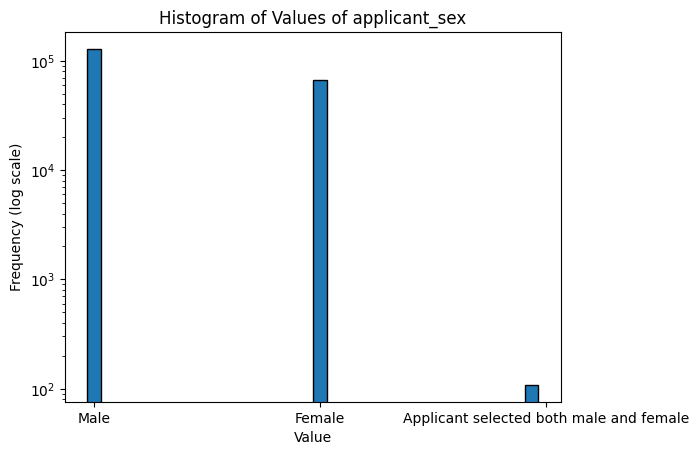

In [10]:

# Map the numerical labels to their descriptions and convert to strings
df_test['applicant_sex_labels'] = df_test['applicant_sex'].map(labels).astype(str)

# Filter out rows with 'nan' values
df_filtered = df_test[df_test['applicant_sex_labels'] != 'nan']

# Create a histogram on a logarithmic scale for the y-axis
plt.hist(df_filtered['applicant_sex_labels'], bins=30, edgecolor='black', log=True, rwidth=0.9, align='left')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Values of applicant_sex')

# Show the plot
plt.show()

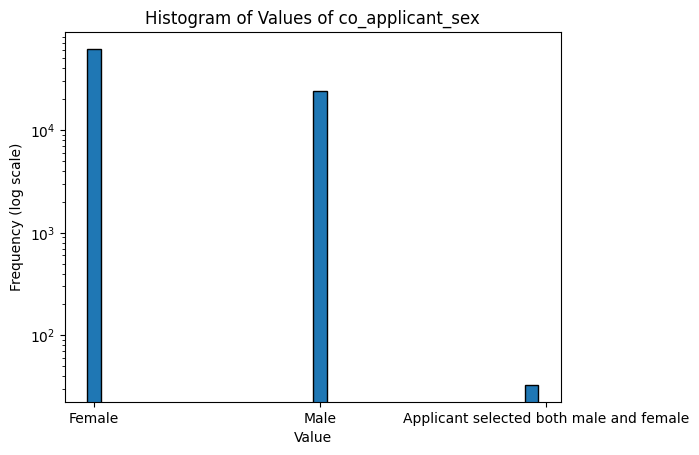

In [11]:

# Map the numerical labels to their descriptions and convert to strings
df_test['co_applicant_sex_labels'] = df_test['co_applicant_sex'].map(labels).astype(str)

# Filter out rows with 'nan' values
df_filtered = df_test[df_test['co_applicant_sex_labels'] != 'nan']

# Create a histogram on a logarithmic scale for the y-axis
plt.hist(df_filtered['co_applicant_sex_labels'], bins=30, edgecolor='black', log=True, rwidth=0.9, align='left')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency (log scale)')
plt.title('Histogram of Values of co_applicant_sex')

# Show the plot
plt.show()

In [12]:
df_filtered= df_filtered.drop(columns=['applicant_sex_labels'])
df_filtered= df_filtered.drop(columns=['co_applicant_sex_labels'])
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85358 entries, 1 to 219767
Data columns (total 33 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   action_taken                              85358 non-null  int64  
 1   loan_type                                 85358 non-null  int64  
 2   lien_status                               85358 non-null  int64  
 3   open_end_line_of_credit                   85358 non-null  int64  
 4   loan_amount                               85358 non-null  int64  
 5   combined_loan_to_value_ratio              83673 non-null  object 
 6   interest_rate                             48750 non-null  object 
 7   total_loan_costs                          48750 non-null  object 
 8   origination_charges                       48750 non-null  object 
 9   loan_term                                 85303 non-null  object 
 10  negative_amortization                 

### Shapiro-Wilk Test for Normality
assess if the combined data is normally distributed.

In [13]:
# Extract data for 'action_taken' and 'applicant_sex'
data_combined1 = df_filtered[['action_taken', 'applicant_sex']]

In [14]:
data_combined1.values

array([[3, 1],
       [3, 2],
       [3, 1],
       ...,
       [1, 2],
       [1, 1],
       [1, 2]], dtype=int64)

In [15]:
# Perform Shapiro-Wilk test
stat_combined1, p_value_combined1 = shapiro(data_combined1)

# Print the results
print('Shapiro-Wilk Test for Combined Data:')
print('  Statistic:', stat_combined1)
print('  p-value:', p_value_combined1)
print('  Is the data normally distributed?', p_value_combined1 > 0.05)


Shapiro-Wilk Test for Combined Data:
  Statistic: 0.6563214063644409
  p-value: 0.0
  Is the data normally distributed? False


C:\Users\asche\anaconda3\envs\Test\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Test for normal, exponential, poisson, gamma distribution

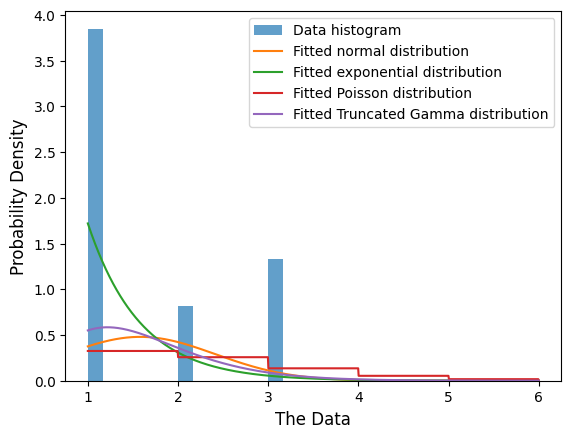

In [16]:
data = data_combined1[['action_taken', 'applicant_sex']].values

# Flatten the data into a 1D array
flattened_data = data.flatten()
flattened_data = flattened_data[flattened_data >= 0]  # Filter out negative or invalid values

# Fit the data to different distributions
params_norm = norm.fit(flattened_data)
params_expon = expon.fit(flattened_data)

# Generate x values for the PDFs
x = np.linspace(min(flattened_data), max(flattened_data), 1000)

# Fit the Poisson distribution
mu_poisson = np.mean(flattened_data)
pdf_poisson = poisson.pmf(x.astype(int), mu_poisson)

# Fit a truncated gamma distribution (truncated at 0 to avoid negative values)
a, loc, scale = gamma.fit(flattened_data, floc=0)
pdf_trunc_gamma = gamma.pdf(x, a, loc=0, scale=scale)

# Generate x values for the PDFs
x = np.linspace(min(flattened_data), max(flattened_data), 1000)
pdf_norm = norm.pdf(x, *params_norm)
pdf_expon = expon.pdf(x, *params_expon)

# Plot the data and fits
plt.hist(flattened_data, bins=30, density=True, alpha=0.7, label="Data histogram")
plt.plot(x, pdf_norm, label="Fitted normal distribution")
plt.plot(x, pdf_expon, label="Fitted exponential distribution")
plt.plot(x, pdf_poisson, label="Fitted Poisson distribution")
plt.plot(x, pdf_trunc_gamma, label="Fitted Truncated Gamma distribution")

plt.xlabel("The Data", fontsize=12)  # Adjust the fontsize here
plt.ylabel("Probability Density", fontsize=12)  # Adjust the fontsize here
plt.legend()
plt.legend(fontsize=10)  # Adjust the fontsize for the legend here
plt.xticks(fontsize=10)  # Adjust the fontsize for the x-axis ticks here
plt.yticks(fontsize=10)  # Adjust the fontsize for the y-axis ticks here

plt.show()

## Plotting Boxplots

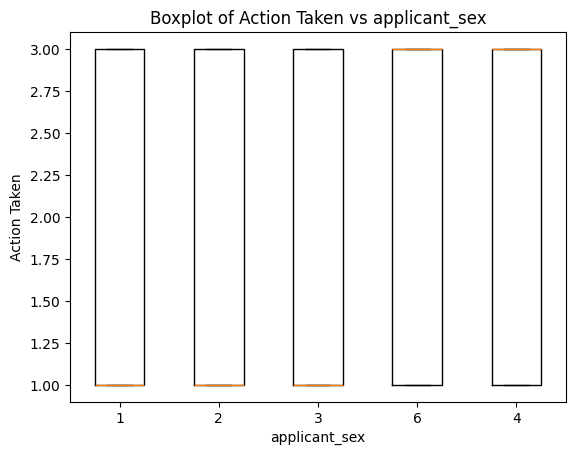

In [17]:
# Create a list of categories (unique values in 'derived_sex')
categories = df_filtered['applicant_sex'].unique()
categories

# Initialize a list to store the data for each category
data_per_category = []


# Iterate over each category and extract the 'action_taken' values
for category in categories:
    data_per_category.append(df_filtered[df_filtered['applicant_sex'] == category]['action_taken'].values)

data_per_category 

# Create a boxplot
plt.boxplot(data_per_category, labels=categories)

# Add labels and title
plt.xlabel('applicant_sex')
plt.ylabel('Action Taken')
plt.title('Boxplot of Action Taken vs applicant_sex')

# Show the plot
plt.show()

# Violin Plot

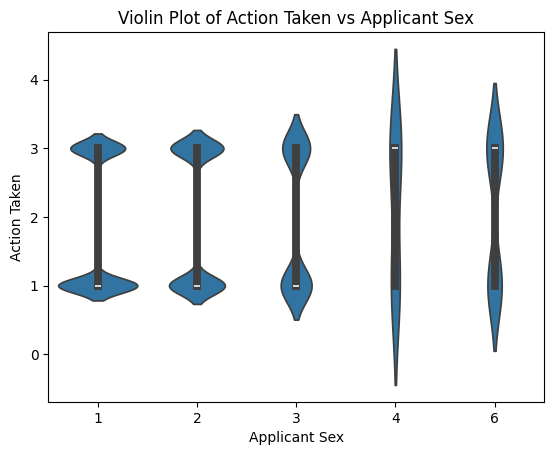

In [18]:
# Create a violin plot
sns.violinplot(x='applicant_sex', y='action_taken', data=df_filtered)

# Add labels and title
plt.xlabel('Applicant Sex')
plt.ylabel('Action Taken')
plt.title('Violin Plot of Action Taken vs Applicant Sex')

# Show the plot
plt.show()

#  the white dot at the center of each "violin" represents the median of the data within that category. 
#  The thicker part of the violin (the "body") represents the interquartile range (IQR), which contains the middle 50% of the data.
#  The thinner sections extending from the body (the "whiskers") indicate the data's minimum and maximum values within 1.5 times the IQR.

##  Barplot

<Axes: xlabel='action_taken', ylabel='Count'>

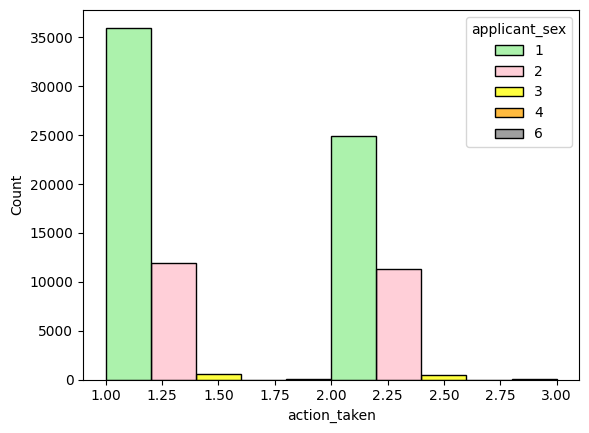

In [19]:
# Filter out the warnings related to is_categorical_dtype and use_inf_as_na
warnings.filterwarnings("ignore", message="is_categorical_dtype is deprecated")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

first_dimension = "action_taken"
horizontal_label = "x label"
second_dimension = "applicant_sex"

sns.histplot(binwidth=1,
            x=first_dimension,
            hue=second_dimension,
            data=df_filtered,
            stat="count",
            multiple="dodge",
            palette=['lightgreen', 'pink', 'yellow', 'orange', 'grey'],
            )  # Adjust the number of bins as needed.


In [20]:
df_test = df_filtered.copy()

# Group by 'action_taken' and 'applicant_sex' and count the occurrences
grouped_data = df_test.groupby(['action_taken', 'applicant_sex']).size().unstack().fillna(0)

# Calculate the total count of each 'action_taken' category
total_counts_action_taken = grouped_data.sum(axis=1)

# Calculate the percentages for each combination
percentage_data = grouped_data.divide(total_counts_action_taken, axis=0) * 100

# Print the percentage data
print("Percentage of each 'action_taken' category for each 'applicant_sex':")
print(percentage_data)

Percentage of each 'action_taken' category for each 'applicant_sex':
applicant_sex          1          2         3         4         6
action_taken                                                     
1              74.161724  24.649860  1.141045  0.006179  0.041193
3              67.744390  30.826496  1.355757  0.010868  0.062490


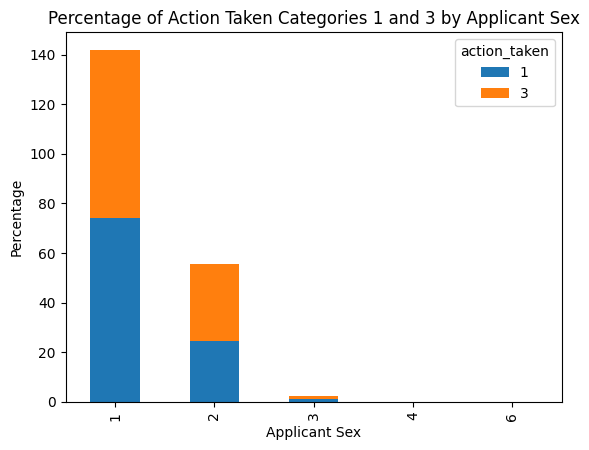

In [21]:

# Filter data for 'action_taken' categories 1 and 3
filtered_data = df_test[df_test['action_taken'].isin([1, 3])]

# Group by 'action_taken' and 'applicant_sex' and count the occurrences
grouped_data = filtered_data.groupby(['action_taken', 'applicant_sex']).size().unstack().fillna(0)

# Calculate the total count of each 'action_taken' category
total_counts_action_taken = grouped_data.sum(axis=1)

# Calculate the percentages for each combination
percentage_data = grouped_data.divide(total_counts_action_taken, axis=0) * 100

# Plot the percentages for 'action_taken' categories 1 and 3
percentage_data.loc[[1, 3]].T.plot(kind='bar', stacked=True)

# Add labels and title
plt.xlabel('Applicant Sex')
plt.ylabel('Percentage')
plt.title('Percentage of Action Taken Categories 1 and 3 by Applicant Sex')

# Show the plot
plt.show()

# Conclusion

The exponential distribution is often used to model the time until an event occurs in a Poisson process, which could be related to the time until a loan is approved or some other event.


- Data: Sex and loan approval (action taken category).

- Distribution: Exponential distribution, modeling the time until loan approval.

- Interpretation: The exponential distribution suggests that the time (or other relevant measure) until a loan is approved may follow this distribution. The rate parameter of the exponential distribution (often denoted as λ, which is the reciprocal of the mean) provides an estimate of how frequently loans are approved.

In [22]:
# Filter data for applicant_sex category 1 and action_taken category 1
data_applicant_sex_1_action_taken_1 = df_test[df_test['applicant_sex'] == 1]['action_taken']

# Calculate the mean of the filtered data
mean_of_data_applicant_sex_1_action_taken_1 = np.mean(data_applicant_sex_1_action_taken_1)

# Calculate the rate parameter (lambda) for applicant_sex category 1 and action_taken category 1
rate_parameter_applicant_sex_1_action_taken_1 = 1 / mean_of_data_applicant_sex_1_action_taken_1

print("Rate parameter (lambda) for the exponential distribution, applicant_sex category 1 and action_taken:", rate_parameter_applicant_sex_1_action_taken_1)

Rate parameter (lambda) for the exponential distribution, applicant_sex category 1 and action_taken: 0.5499643530760137


In [23]:
import numpy as np

# Filter data for applicant_sex category 1 and action_taken category 1
data_applicant_sex_2_action_taken_1 = df_test[df_test['applicant_sex'] == 2]['action_taken']

# Calculate the mean of the filtered data
mean_of_data_applicant_sex_2_action_taken_1 = np.mean(data_applicant_sex_2_action_taken_1)

# Calculate the rate parameter (lambda) for applicant_sex category 1 and action_taken category 1
rate_parameter_applicant_sex_2_action_taken_1 = 1 / mean_of_data_applicant_sex_2_action_taken_1

print("Rate parameter (lambda) for the exponential distribution, applicant_sex category 2 and action_taken:", rate_parameter_applicant_sex_2_action_taken_1)


Rate parameter (lambda) for the exponential distribution, applicant_sex category 2 and action_taken: 0.5067599878276746


In [24]:
df_filtered.to_csv('2_distribution_applicant_sex_and_action_taken.csv', index=False)